### Task IV: Quantum Generative Adversarial Network (QGAN)

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task. 

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [[Download Input]](https://drive.google.com/file/d/1r_MZB_crfpij6r3SxPDeU_3JD6t6AxAj/view). In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this 
task. The signal events are labeled with 1 while the background events are labeled with 0. 
Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC). 


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
import sympy

from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import shuffle
from tqdm import tqdm

2024-04-07 13:05:36.016135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-07 13:05:36.016207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-07 13:05:41.336820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 13:05:41.337001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-07 13:05:41.337078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcub

#### Loading and processing data

Our dataset has two categories: signal events (labelled as 1) and background events (labelled as 0). Our goal is to classify these events using a Generative Adversarial Network (GAN); that means the discriminator network will not only determine if data is real or fake, but also perform binary classification. 

Achieving this first requires suitable labels for our data. We will apply one-hot encoding to transform our class labels for better expressiveness, add indicator for real/fake data, and convert to spin binary format to be compatible with quantum circuit output. Thus, for the first two bits:
* [1, -1] will indicate label 0.
* [-1, 1] will indicate label 1.

And for the third bits:

* [1] will indicate real data,
* [-1] will indicate fake data.


In [2]:
# Load dataset
data = np.load('data/QIS_EXAM_200Events.npz', allow_pickle=True)
X_train_data = data['training_input'].item()
X_test_data = data['test_input'].item()

# Prepare training data
X_train_0 = X_train_data['0']
X_train_1 = X_train_data['1']
X_train = np.concatenate((X_train_0, X_train_1), axis=0)

# Prepare testing data
X_test_0 = X_test_data['0']
X_test_1 = X_test_data['1']
X_test = np.concatenate((X_test_0, X_test_1), axis=0)

# Prepare labels
y_train_ = np.array([0] * len(X_train_0) + [1] * len(X_train_1))
y_test_ = np.array([0] * len(X_test_0) + [1] * len(X_test_1))
# Process: one-hot encoding / binary spin -1 and +1 / real indicator
y_train = np.hstack((np.eye(2)[y_train_]*2-1, np.ones((len(y_train_), 1))))
y_test = np.hstack((np.eye(2)[y_test_]*2-1, np.ones((len(y_test_), 1))))

# y_train = np.hstack((y_train_[:, np.newaxis]*2-1, np.ones((len(y_train_), 1))))
# y_test = np.hstack((y_test_[:, np.newaxis]*2-1, np.ones((len(y_test_), 1))))

# Check
print("X:", X_train[0], X_train[-1])
print("y:", y_train[0], y_train[-1])
print("y:", y_test[0], y_test[-1])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X: [-0.43079088  0.86834819 -0.92614721 -0.92662029 -0.56900862] [ 0.88125135 -0.95437964 -0.66664384 -0.78187561 -0.64345757]
y: [ 1. -1.  1.] [-1.  1.  1.]
y: [ 1. -1.  1.] [-1.  1.  1.]
(100, 5) (100, 3)
(100, 5) (100, 3)


#### Model Architecture

The work in [1] has explored using parameterized quantum circuit (PQC) as the generator and a classical neral network as the discrimator in the GAN architecture. In this experiment, we'll explore utilizing PQCs as both the generator (to create synthetic data) and the discriminator (to classify the data as real or fake and to perform binary classification):   

Discriminator Circuit: Inputs will be embedded using angle encoding across 5 qubits (corresponding to `num_features = 5`). The circuit will output 3 qubits (corresponding to `num_outputs = 3`), which will correspond the data labels as outlined above.

Generator Circuit: Outputs from 5 qubits i.e `num_features = 5` will serve as synthetic input to the discriminator. Additional qubits defined by `num_gen` are used for entanglement procedures to enhance the generation process.

The number of gate layers will be defined in `gen_layer` and `disc_layer`. The two PQCs will be trained with classical optimization method (gradient descent etc.) to minimize the loss functions specified in [1] (also commonly found in conditional GAN approach). This is a typical hybrid approach commonly utilized in NISQ-era quantum machine learning. 

In [3]:
# Defining global variables for quantum circuits
num_gen = 5 # i.e gen ancilla qubits
num_features = 5 # i.e data qubits
num_outputs = 3 # i.e disc ancilla/output qubits
gen_layer = 2
disc_layer = 2

qubits = cirq.GridQubit.rect(1, num_gen + num_features + num_outputs)

We will construct the PQCs as follow. The gate functions added by `add_one_qubit_gate` are parameterized with `sympy.Symbol` if `params` is not defined ad otherwise have fixed value. This is for conveniently re-constructing a circuit with fixed discriminator and parameterized generator to train the later, as we could only modify the trainability of `tfq.layers.PQC` as a whole. 

In [4]:
def add_one_qubit_gate(circuit, qubits, prefix, params):
    if params is None:
        for i, qubit in enumerate(qubits):
            circuit.append(cirq.Z(qubit)**sympy.Symbol(f'{prefix}_{3*i}'))
            circuit.append(cirq.Y(qubit)**sympy.Symbol(f'{prefix}_{3*i+1}'))
            circuit.append(cirq.Z(qubit)**sympy.Symbol(f'{prefix}_{3*i+2}'))
    else:   
        assert len(params) == 3*len(qubits)
        for i, qubit in enumerate(qubits):
            circuit.append(cirq.Z(qubit)**params[3*i])
            circuit.append(cirq.Y(qubit)**params[3*i+1])
            circuit.append(cirq.Z(qubit)**params[3*i+2])

def add_entangling_gate(circuit, qubits):
    for i in range(len(qubits) - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))

def create_gen_circuit(qubits, layer, init_weights=None):
    circuit = cirq.Circuit()
    
    gen_aux_qubits = qubits[:-(num_features+num_outputs)]
    data_qubits = qubits[-(num_features+num_outputs):-num_outputs]
    output_qubits = qubits[-num_outputs:]

    gen_qubits = gen_aux_qubits + data_qubits
    
    # Apply RY gates with random angles to the data qubits
    random_angles = np.random.normal(loc=0, scale=np.pi/3, size=len(data_qubits))
    for i, angle in enumerate(random_angles):
        circuit.append(cirq.ry(angle)(data_qubits[i]))

    # Add layers
    params = None
    for i in range(layer):
        if init_weights is not None:
            params = init_weights[3*len(gen_qubits)*i:3*len(gen_qubits)*(i+1)]
        add_one_qubit_gate(circuit, gen_qubits, f'gen_{i}', params)
        add_entangling_gate(circuit, gen_qubits)
    
    if init_weights is not None:
        params = init_weights[-3*len(data_qubits):] # Past error here

    add_one_qubit_gate(circuit, data_qubits, f'gen_out', params)
    # print(circuit)
    return circuit

def create_disc_circuit(qubits, layer, init_weights=None):
    circuit = cirq.Circuit()
    
    gen_aux_qubits = qubits[:-(num_features+num_outputs)]
    data_qubits = qubits[-(num_features+num_outputs):-num_outputs]
    output_qubits = qubits[-num_outputs:]

    disc_qubits = data_qubits + output_qubits
    
    # Hadamard layer for data qubits
    for qubit in data_qubits:
        circuit.append(cirq.H(qubit))

    # Add layers
    params = None
    for i in range(layer):
        if init_weights is not None:
            params = init_weights[3*len(disc_qubits)*i:3*len(disc_qubits)*(i+1)]
        add_one_qubit_gate(circuit, disc_qubits, f'disc_{i}', params)
        add_entangling_gate(circuit, disc_qubits)
        
    if init_weights is not None:
        params = init_weights[-3*len(output_qubits):]
        
    add_one_qubit_gate(circuit, output_qubits, f'disc_out', params)
    # print(circuit)
    return circuit


def create_gen_disc_circuit(qubits, gen_layer, disc_layer, init_weights=None):
    gen_disc_circuit = cirq.Circuit()

    # Add the generator and discriminator circuits
    gen_disc_circuit += create_gen_circuit(qubits, gen_layer)
    gen_disc_circuit += create_disc_circuit(qubits, disc_layer, init_weights=init_weights)

    return gen_disc_circuit

gen_disc_circuit = create_gen_disc_circuit(qubits, gen_layer, disc_layer)
print(gen_disc_circuit)

(0, 0): ────Z^gen_0_0─────Y^gen_0_1────Z^gen_0_2────@────────────Z^gen_1_0───Y^gen_1_1───Z^gen_1_2───────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                    │                                                            │
(0, 1): ────Z^gen_0_3─────Y^gen_0_4────Z^gen_0_5────X────────────@───────────Z^gen_1_3───Y^gen_1_4───Z^gen_1_5───X────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

#### Loss Functions

Next, we will define the loss functions to train our models as well as some metric for evaluation: 

**Generator Loss Function**

The generator's loss function proposed in [1] is given by:

$$ \mathcal{L}_{gen} = - \sum_{z \sim p_z(z)} \log D(G(z)) $$

This represents the part of the GAN loss that encourages the generator to produce data which the discriminator is more likely to classify as real, which is adopted widely in GAN architecture. 


**Discriminator Loss Function**

The discriminator 's loss function proposed in [1] incorporates both discriminator and classifier objectives such that:

$$ \mathcal{L_{disc}} = a_c \cdot \mathcal{L}_{\text{C}} + (1 - a_c) \cdot \mathcal{L}_{\text{D}} $$

where:

- $\mathcal{L}_{D} = \sum_{x \sim p_{\text{data}}(x)} \log D(x) + \sum_{z \sim p_z(z)} \log(1 - D(G(z)))$ is the discriminator's loss, aiming to differentiate between real and fake data.
- $\mathcal{L}_{C}$ is the classifier's loss, such as cross-entropy.
- $a_c$ is the coefficient that balances the importance of the classifier's loss versus the discriminator's loss.

This combined loss function is often adopted in conditional GAN architecture that aim to not only generate data that aims to generate data conditioned on certain inputs, enabling the generation of more specific and diverse data samples.

**Custom Accuracy**

We also define an accuracy function as:

$$ \text{Accuracy} = \frac{\sum (C_{\text{true}} = C_{\text{pred}}) \cdot D_{\text{true}}}{\text{count}(D_{\text{true}} = 1) } $$

i.e the summation over instances of the predicted class matching the true class, weighted by real indicator $D_{\text{true}}$.

In [5]:
ac = 0.50 

@tf.function
def disc_loss(y_true,y_pred):
    
    D_true = (y_true[:,num_outputs-1]+1)/2
    D_pred = (y_pred[:,num_outputs-1]+1)/2
    # Loss in predicting true or fake
    L_d = -(tf.math.log(D_pred + 1e-15)*D_true + tf.math.log(1- D_pred +1e-15)*(1-D_true))
    L_d = tf.reduce_mean(L_d, axis=0)
    
    C_true = (y_true[:,:num_outputs-1]+1)/2
    C_pred = (y_pred[:,:num_outputs-1]+1)/2
    # Loss in classification
    D_true_size = tf.cast(tf.size(tf.where(D_true==1 ),out_type= tf.int32), dtype=tf.float32) + 1e-15
    L_c = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true,C_pred)*D_true)/D_true_size

    # Total Loss of discrminator
    Loss = ((L_d)*(1-ac) + L_c*ac)
    return Loss

@tf.function
def gen_loss(y_true, y_pred):
    y_pred = (y_pred + 1) / 2
    return tf.reduce_mean((-1) * tf.math.log(y_pred), axis=0)


@tf.function
def custom_acc(y_true,y_pred):
    D_true = (y_true[:,num_outputs-1]+1)/2

    C_real_true = (y_true[:,:num_outputs-1]+1)/2
    C_real_pred = (y_pred[:,:num_outputs-1]+1)/2
    
    C_real_true = tf.math.argmax(C_real_true,axis=1)
    C_real_pred = tf.math.argmax(C_real_pred,axis=1)
    D_true_size = tf.cast(tf.size(tf.where(D_true==1 ),out_type= tf.int32), dtype=tf.float32) + 1e-15

    same = tf.cast(C_real_true == C_real_pred, tf.float32)*D_true
    return tf.math.reduce_sum(same)/D_true_size


Finally we will define some functions to embed values as inputs into quantum circuit, namely: 

* `generate_data`: Embed value using the angle encoding technique. 

* `generate_identity`: Generates direct empty quantum embeddings.

* `generate_fake_data`: Generates fixed QGAN generator as input to train discriminator.

Afterward, we will also create the Tensorflow-based hybrid models for optimizing the parameters of generator and discriminator PQCs. 

In [6]:
def generate_identity(X):
    return [cirq.Circuit() for _ in X]

def generate_data(X, qubits):
    quantum_data = []
    for i, sample in enumerate(X):
        circuit = cirq.Circuit([cirq.ry(sample[bit])(qubits[num_gen+bit]) for bit in range(len(sample))])
        quantum_data.append(circuit)
    return quantum_data

def generate_fake_data(X, qubits, layer, init_weights=None):
    quantum_data = []  

    length = len(X) # Generate same number of fake data as of real
    for i in range(length):
        # Generate fake quantum data as configs of generator_circuit
        circuit = create_gen_circuit(qubits,
                                     layer,
                                     init_weights=init_weights)
        quantum_data.append(circuit)  
    return quantum_data

def discriminator_model(disc_layer, init_weights=None):
    disc_readout_operators = [cirq.Z(qubits[-(num_outputs) + q]) for q in range(num_outputs)]
    
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    pqc = tfq.layers.PQC(
        create_disc_circuit(qubits, disc_layer, init_weights=init_weights), 
        disc_readout_operators, 
        name = 'qdisc_layer')(data_input)
    
    # Define and compile the model
    model = tf.keras.Model(inputs=[data_input], outputs=[pqc], name='qdisc_model')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=disc_loss,
                  metrics=[custom_acc])
    return model

def generator_model(gen_layer, disc_layer, init_weights):
    gen_readout_operators = [cirq.Z(qubits[-1])] 
    
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    
    pqc = tfq.layers.PQC(
        create_gen_disc_circuit(qubits, gen_layer, disc_layer, init_weights=init_weights),
        gen_readout_operators,
        name = 'qgen_layer')(data_input)
    
    model = tf.keras.Model(inputs=[data_input], outputs=[pqc], name='qgen_model')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=gen_loss)
    return model

class EpochProgressBar(Callback):
    def __init__(self, total_epochs, metrics=[]):
        super().__init__()
        self.total_epochs = total_epochs
        self.metrics = metrics
        self.progress_bar = None

    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(total=self.total_epochs, unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        description = f'Epoch {epoch+1}/{self.total_epochs}, loss: {logs.get("loss"):.4f}'
        for metric in self.metrics:
            description += f', {metric}: {logs.get(metric):.4f}'
        self.progress_bar.set_description(description)
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Convert generated identity quantum data to TensorFlow Quantum tensors
identity_data = tfq.convert_to_tensor(generate_identity(X_train))

# Create identity labels (all zeros) corresponding to each identity data sample
# this label will be used in the quantum fake data 
identity_label = np.zeros((len(identity_data),))

#### Training

In [7]:
qdisc_model = discriminator_model(disc_layer)
qdisc_model.summary()

qgen_model = generator_model(gen_layer, disc_layer, qdisc_model.get_weights()[0])
qgen_model.summary()

Model: "qdisc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 qdisc_layer (PQC)           (None, 3)                 57        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Model: "qgen_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 qgen_layer (PQC)            (None, 1)                 75        
                                                                 
Total params: 75
Trainable params: 75
N

In [8]:
print(create_disc_circuit(qubits, layer=disc_layer, init_weights=qdisc_model.get_weights()[0]))
print(qdisc_model.get_weights()[0])

(0, 5): ────H─────────────Z^1.6129104───Y^4.687219────Z^3.6136243───@───Z^0.51752305───Y^1.5132092───Z^4.9433455───────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                    │                                                              │
(0, 6): ────H─────────────Z^1.9331963───Y^5.882059────Z^5.842495────X───@──────────────Z^4.1624074───Y^4.841298────Z^1.2640533─────X─────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                        │                                                                        │
(0, 7): ────H─────────────Z^4.012867────Y^1.3455528───Z^2.063283────────X──────────────@─────────────Z^3.0865777───Y^3.355956──────Z^3.2469296───X────────────@─────────────────────────────────

In [9]:
print(generate_fake_data(X_train[0], qubits, gen_layer, qgen_model.get_weights()[0])[0])
print(qgen_model.get_weights()[0])

(0, 0): ───Z^3.372555────Y^2.5332525───Z^3.2357063────@─────────────Z^1.659395───Y^1.1696484───Z^0.75395834──────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                      │                                                                      │
(0, 1): ───Z^1.0542687───Y^1.2002869───Z^2.5888247────X─────────────@────────────Z^4.4614925───Y^1.6994852────Z^6.2182417────X─────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                    │                                                                      │
(0, 2): ───Z^1.289564────Y^4.8015785───Z^3.4318066──────────────────X────────────@─────────────Z^0.839674─────Y^5.9050016────Z^5.307586───

Cycle 1 with ac = 0.5


Epoch 600/600, loss: 0.3584: 100%|██████████| 600/600 [06:19<00:00,  1.58epoch/s]


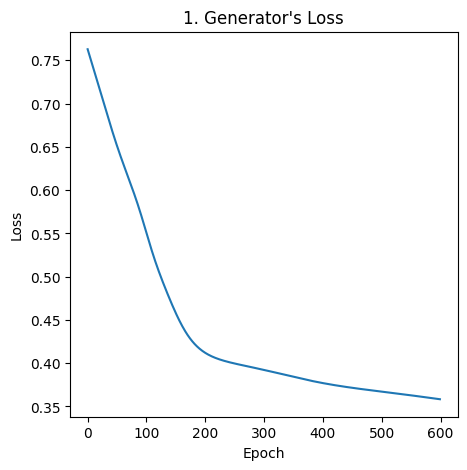

Epoch 246/300, loss: 0.4521, custom_acc: 0.8153, val_custom_acc: 0.7732, val_loss: 0.4859:  82%|████████▏ | 246/300 [05:24<00:58,  1.09s/epoch]


Epoch 00246: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


Epoch 266/300, loss: 0.4515, custom_acc: 0.7411, val_custom_acc: 0.7732, val_loss: 0.4838:  89%|████████▊ | 266/300 [05:47<00:44,  1.31s/epoch]



Epoch 00266: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch: 226.
Epoch 00266: early stopping


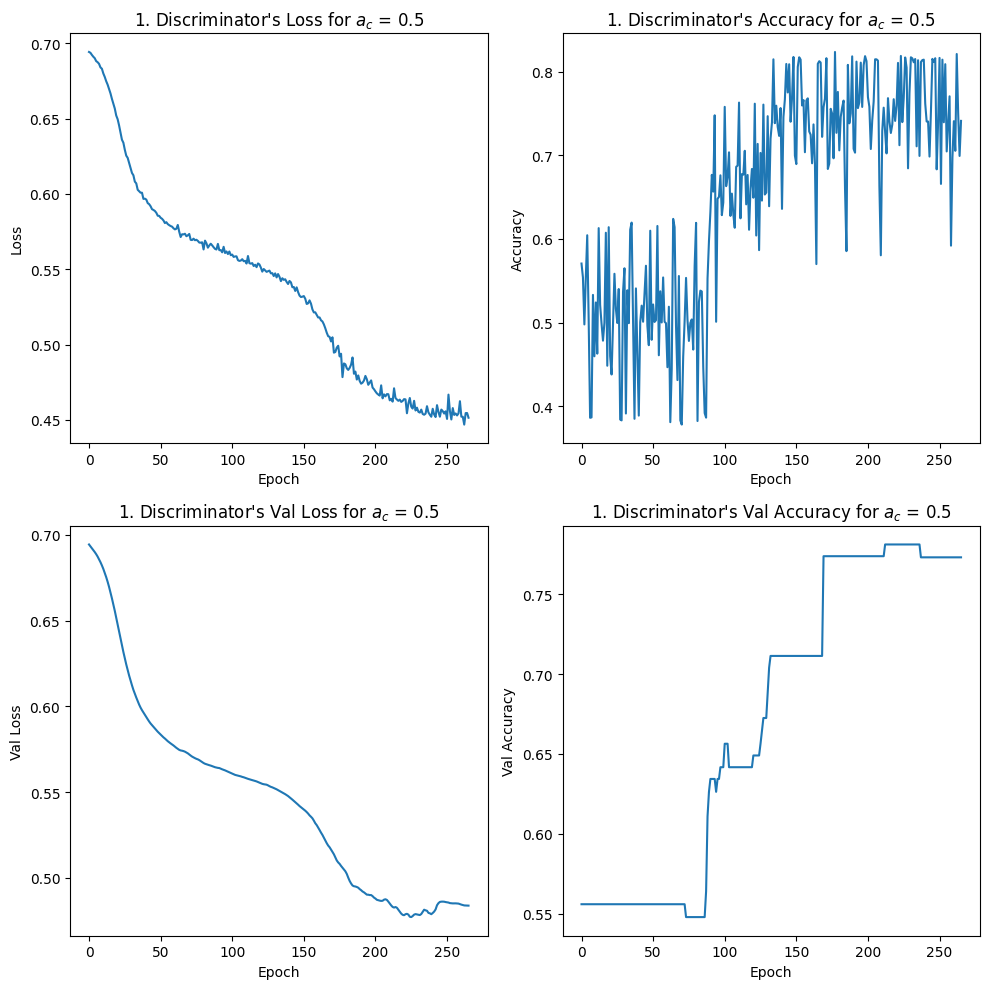

Cycle 2 with ac = 0.75


Epoch 600/600, loss: 0.3472: 100%|██████████| 600/600 [05:55<00:00,  1.69epoch/s]


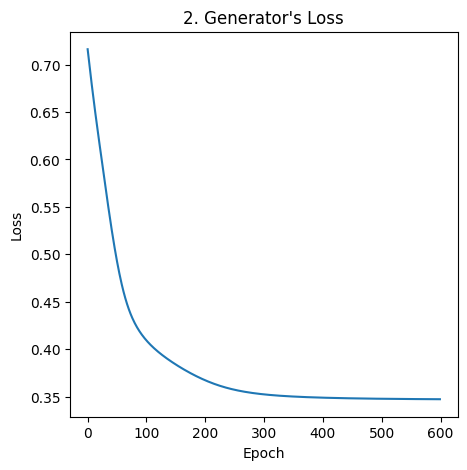

Epoch 66/300, loss: 0.4698, custom_acc: 0.7299, val_custom_acc: 0.7107, val_loss: 0.5016:  22%|██▏       | 66/300 [01:12<04:14,  1.09s/epoch]


Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


Epoch 86/300, loss: 0.4654, custom_acc: 0.7111, val_custom_acc: 0.7107, val_loss: 0.5012:  29%|██▊       | 86/300 [01:34<03:49,  1.07s/epoch]


Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


Epoch 110/300, loss: 0.4693, custom_acc: 0.7743, val_custom_acc: 0.7107, val_loss: 0.5013:  37%|███▋      | 110/300 [02:02<03:42,  1.17s/epoch]


Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


Epoch 130/300, loss: 0.4679, custom_acc: 0.7830, val_custom_acc: 0.7107, val_loss: 0.5013:  43%|████▎     | 130/300 [02:24<03:09,  1.12s/epoch]


Epoch 00130: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.


Epoch 133/300, loss: 0.4738, custom_acc: 0.5777, val_custom_acc: 0.7107, val_loss: 0.5013:  44%|████▍     | 133/300 [02:27<03:05,  1.11s/epoch]


Restoring model weights from the end of the best epoch: 93.
Epoch 00133: early stopping


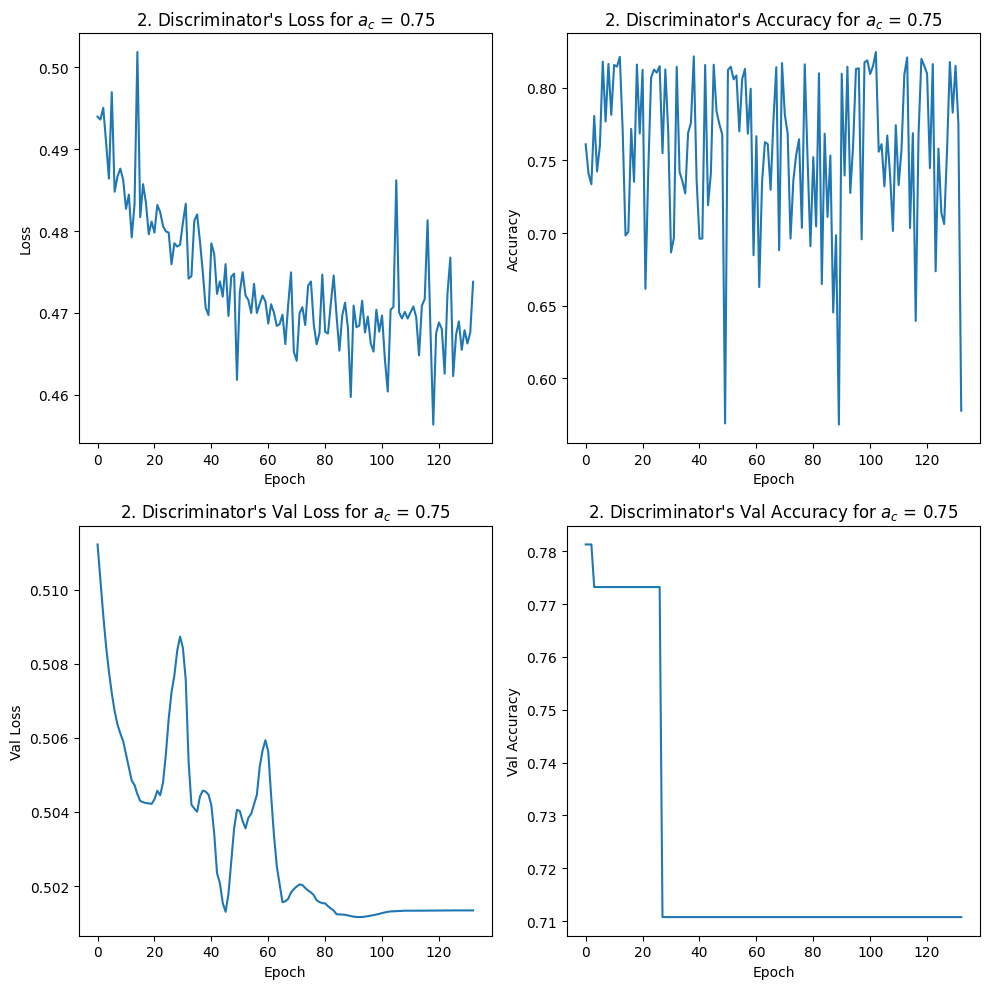

Cycle 3 with ac = 1


Epoch 600/600, loss: 0.2348: 100%|██████████| 600/600 [05:41<00:00,  1.76epoch/s]


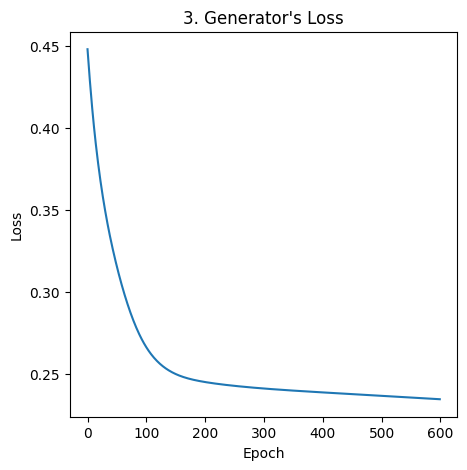

Epoch 28/300, loss: 0.4768, custom_acc: 0.8101, val_custom_acc: 0.7107, val_loss: 0.5183:   9%|▉         | 28/300 [00:31<04:53,  1.08s/epoch]


Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


Epoch 48/300, loss: 0.4720, custom_acc: 0.8152, val_custom_acc: 0.7107, val_loss: 0.5185:  16%|█▌        | 48/300 [00:53<04:32,  1.08s/epoch]


Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


Epoch 49/300, loss: 0.4752, custom_acc: 0.6370, val_custom_acc: 0.7107, val_loss: 0.5185:  16%|█▋        | 49/300 [00:54<04:41,  1.12s/epoch]


Restoring model weights from the end of the best epoch: 9.
Epoch 00049: early stopping


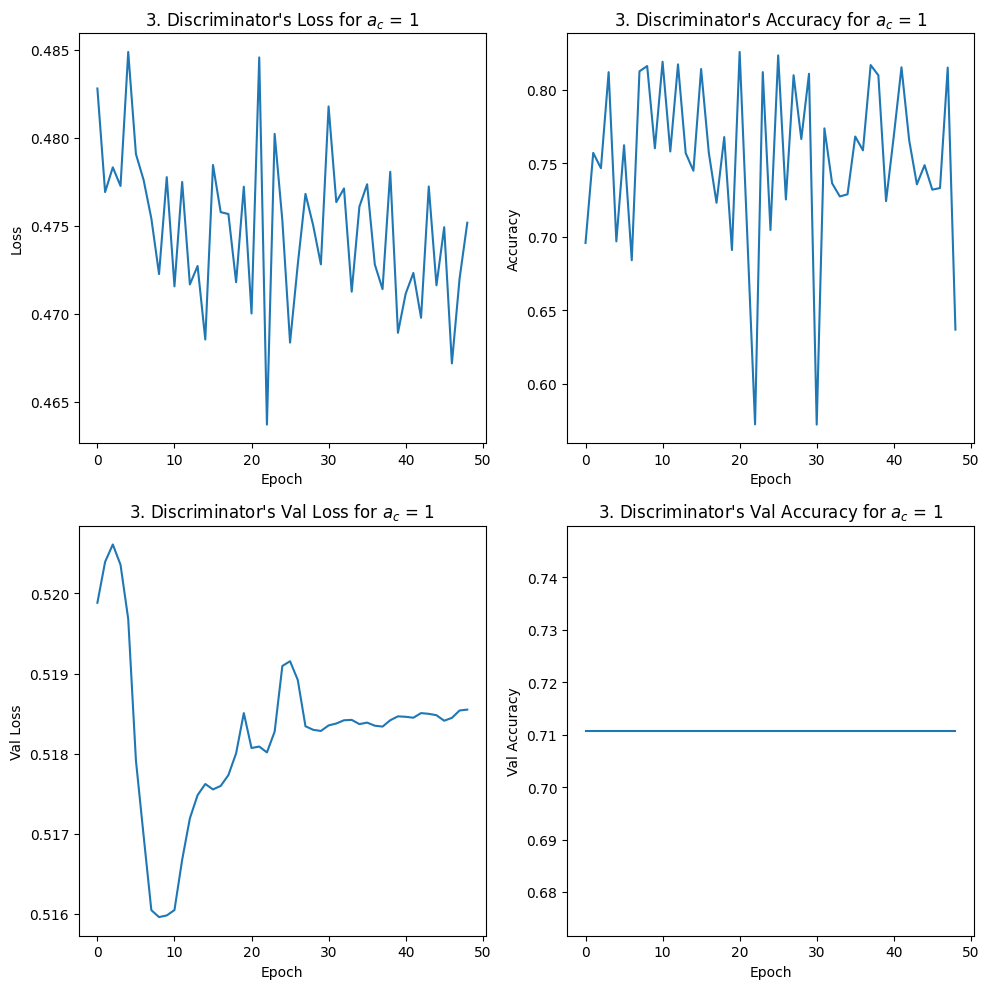

In [10]:
disc_epoch = 300
gen_epoch = 600

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=20,
    min_lr=1e-7,
    verbose=2,
)

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True,
    verbose=2,
)

disc_progress_bar = EpochProgressBar(disc_epoch, metrics=['custom_acc', 'val_custom_acc', 'val_loss'])
gen_progress_bar = EpochProgressBar(gen_epoch)

def train_conditional_gan_cycle(ac_values): 
    global ac, qdisc_model, qgen_model
    
    for cycle, ac_value in enumerate(ac_values):
        print(f"Cycle {cycle + 1} with ac = {ac_value}")
        ac = ac_value  # Update the global C value
        
        # gen_checkpoint_path = f'./model_checkpoints/gen_model_cycle_{cycle + 1}_ac_{ac_value}.csv'
        # gen_model_cp = ModelCheckpoint(gen_checkpoint_path,
        #                                monitor='loss',
        #                                save_weights_only=True,
        #                                save_best_only=True,
        #                                mode='min')
        disc_checkpoint_path = f'./model_checkpoints/disc_model_cycle_{cycle + 1}_ac_{ac_value}.csv'
        disc_model_cp = ModelCheckpoint(disc_checkpoint_path, 
                                        monitor='val_custom_acc',
                                        save_weights_only=True,
                                        save_best_only=True,
                                        mode='max'),
        
        best_qdist_weights = qdisc_model.get_weights()[0]
        best_qgen_weights = qgen_model.get_weights()[0]
        
        # Reinitiate the discriminator and generator models
        qdisc_model = discriminator_model(disc_layer)
        qdisc_model.get_layer('qdisc_layer').set_weights([best_qdist_weights])
        
        qgen_model = generator_model(gen_layer, disc_layer, best_qdist_weights)
        qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
        
        # Fit the Generator Model
        logs_gen = qgen_model.fit(x=identity_data, y=identity_label, epochs=gen_epoch, batch_size=100, verbose=0, 
                                  callbacks=[gen_progress_bar, 
                                             ])

        # Generator plot
        plt.figure(figsize=(5, 5))  # Adjusted to be square and approximate size of one 2x2 subplot
        plt.plot(logs_gen.history['loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"{cycle + 1}. Generator's Loss")
        plt.show()
        
        # Prepare data and labels for discriminator
        X_gen_train = generate_data(X_train, qubits) + generate_fake_data(X_train, qubits, gen_layer, best_qgen_weights)
        X_gen_test = generate_data(X_test, qubits) + generate_fake_data(X_test, qubits, gen_layer, best_qgen_weights)
        
        y_fake = np.zeros((len(X_train), num_outputs))
        y_fake[:, num_outputs-1] = -1  # Indicating fake data
        
        y_gen_train = np.concatenate((y_train, y_fake), axis=0)
        y_gen_test = np.concatenate((y_test, y_fake), axis=0)
        
        # Shuffle data
        X_gen_train, y_gen_train = shuffle(X_gen_train, y_gen_train, random_state=0)
        X_gen_test, y_gen_test = shuffle(X_gen_test, y_gen_test, random_state=0)
        
        X_gen_train = tfq.convert_to_tensor(X_gen_train)
        X_gen_test = tfq.convert_to_tensor(X_gen_test)
        
        # Fit the Discriminator Model
        logs_disc = qdisc_model.fit(x=X_gen_train, y=y_gen_train, batch_size=64, epochs=disc_epoch, verbose=0, 
                                    callbacks=[disc_progress_bar, 
                                               reduce_lr,
                                               early_stopping,
                                               disc_model_cp,
                                               ], 
                                    validation_data=(X_gen_test, y_gen_test))

        # Discriminator plot
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjusted to 2 rows, 2 columns

        axs[0, 0].plot(logs_disc.history['loss'])
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].set_title(f"{cycle + 1}. Discriminator's Loss for $a_c$ = {ac_value}")

        axs[0, 1].plot(logs_disc.history['custom_acc'])
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].set_title(f"{cycle + 1}. Discriminator's Accuracy for $a_c$ = {ac_value}")

        axs[1, 0].plot(logs_disc.history['val_loss'])
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Val Loss')
        axs[1, 0].set_title(f"{cycle + 1}. Discriminator's Val Loss for $a_c$ = {ac_value}")

        axs[1, 1].plot(logs_disc.history['val_custom_acc'])
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Val Accuracy')
        axs[1, 1].set_title(f"{cycle + 1}. Discriminator's Val Accuracy for $a_c$ = {ac_value}")

        plt.tight_layout()
        plt.show()


ac_values = [0.5, 0.75, 1] 
train_conditional_gan_cycle(ac_values)

The validation accuracy initially reached 78% in the first cycle, then dropped and stabilized at 71% during the second and third cycles. This indicates our model likely overfitted after the first cycle. The overfitting is not surprising since the custom accuracy metric does not depend on $a_c$ coefficient, and the generated data lack class information. Consequently, the model has only learned to classify based on the training set, leading to overfitting.

Next, we would like to explore whether the generator can produce data with class-specific information i.e by only use information from one class. 


#### References
* [1] K. Nakaji and N. Yamamoto, “Quantum semi-supervised generative adversarial network for enhanced data classification,” Sci Rep, vol. 11, no. 1, p. 19649, Oct. 2021, doi: 10.1038/s41598-021-98933-6.